In [1]:
from astropy.io import fits
from stwcs import updatewcs
from drizzlepac import astrodrizzle, ablot
import glob, os, shutil
from multiprocessing import Pool
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from matplotlib.colors import PowerNorm
from stsci.tools import teal
%matplotlib inline

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet


The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


In [2]:
cd /grp/hst/wfc3n/vbajaj/short_term_pers

/grp/hst/wfc3n/vbajaj/short_term_pers


In [3]:
# Pool(8).map(updatewcs.updatewcs, glob.glob('*flt.fits'))

In [4]:
def driz_single(im):
    flts = sorted(glob.glob('*flt.fits'))
    if os.path.exists(flts[0].replace('flt', 'drz')):
        ref = flts[0].replace('flt', 'drz')
        astrodrizzle.AstroDrizzle(im,final_refimage=ref,
                                  median=False,blot=False,driz_cr=False, final_wcs=True,
                                  final_rot=None,final_scale=None,final_outnx=1200,final_outny=1200)
    else:
        astrodrizzle.AstroDrizzle(im,
                                  median=False,blot=False,driz_cr=False,final_wcs=True,
                                  final_rot=None,final_scale=None,final_outnx=1200,final_outny=1200)

In [16]:
# This makes the single drizzled science images
# only need to run this once
# teal.teal('astrodrizzle')
for f in sorted(glob.glob('*flt.fits')):
    driz_single(f)

Validation warnings for: /Users/vbajaj/.teal/astrodrizzle.cfg
	"STEP 7: DRIZZLE FINAL COMBINED IMAGE.final_maskval" is missing.
INPUT_DICT: {'final_outnx': 1200, 'final_outny': 1200, 'final_rot': None, 'final_wcs': True, 'median': False, 'final_scale': None, 'blot': False, 'driz_cr': False, 'input': 'icrr01y7q_flt.fits'}
Setting up logfile :  astrodrizzle.log

AstroDrizzle Version 2.1.6(9-Aug-2016) started at: 16:21:07.237 (07/12/2016)

==== Processing Step  Initialization  started at  16:21:07.314 (07/12/2016)

********************************************************************************

*

*  Estimated memory usage:  up to 24 Mb.

*  Output image size:       1200 X 1200 pixels. 

*  Output image file:       ~ 16 Mb. 

*  Cores available:         1

*

********************************************************************************

==== Processing Step  Initialization  finished at  16:21:10.779 (07/12/2016)

==== Processing Step  Static Mask  started at  16:21:10.97 (07/12/2016)


In [13]:
#  Prints the exposure information

flts = sorted(glob.glob('*flt.fits'))
for f in flts:
#     drz = f.replace('flt', 'drz')
    fhdr = fits.getheader(f)
    print f, fhdr['FILTER'], fhdr['TIME-OBS'], fhdr['POSTARG1'], fhdr['POSTARG2'], fhdr['EXPTIME']

icrr01y7q_flt.fits F140W 21:32:57 0.0 0.0 352.939514
icrr01y8q_flt.fits F140W 21:39:56 2.23685 1.99913 352.939514
icrr01yaq_flt.fits F140W 21:46:55 4.47369 3.99826 352.939514
icrr01ycq_flt.fits F140W 21:53:54 6.71054 5.99739 352.939514
icrr01yeq_flt.fits F140W 22:00:53 8.94739 7.99652 352.939514
icrr01ygq_flt.fits F140W 22:07:52 11.18423 9.99564 352.939514
icrr01yiq_flt.fits F140W 22:14:51 13.42108 11.99477 352.939514


delta_drz.fits icrw05k2q_flt.fits icrw05k2q_delta.fits
Using coordinate transformation defined by user...
Output blotted images scaled by exptime of 4.167226
Added 0.0 counts back in to blotted image as sky.
INFO: 
        coefficients from output header, and stripping "-SIP" from output CTYPE
        if it was originally present.

        Therefore astrometry obtained for output image may be different from
        original image because SIP is no longer present.

        Please inspect the headers of input and output images to verify, and
        modify the headers if necessary.
         [astropy.wcs.wcs]
Found RULEFILE for  wfc3  of:  /Users/vbajaj/anaconda2/envs/astroconda/lib/python2.7/site-packages/fitsblender/wfc3_header.rules
Created output image: icrw05k2q_delta.fits
[296 286] [273 241]
10 32


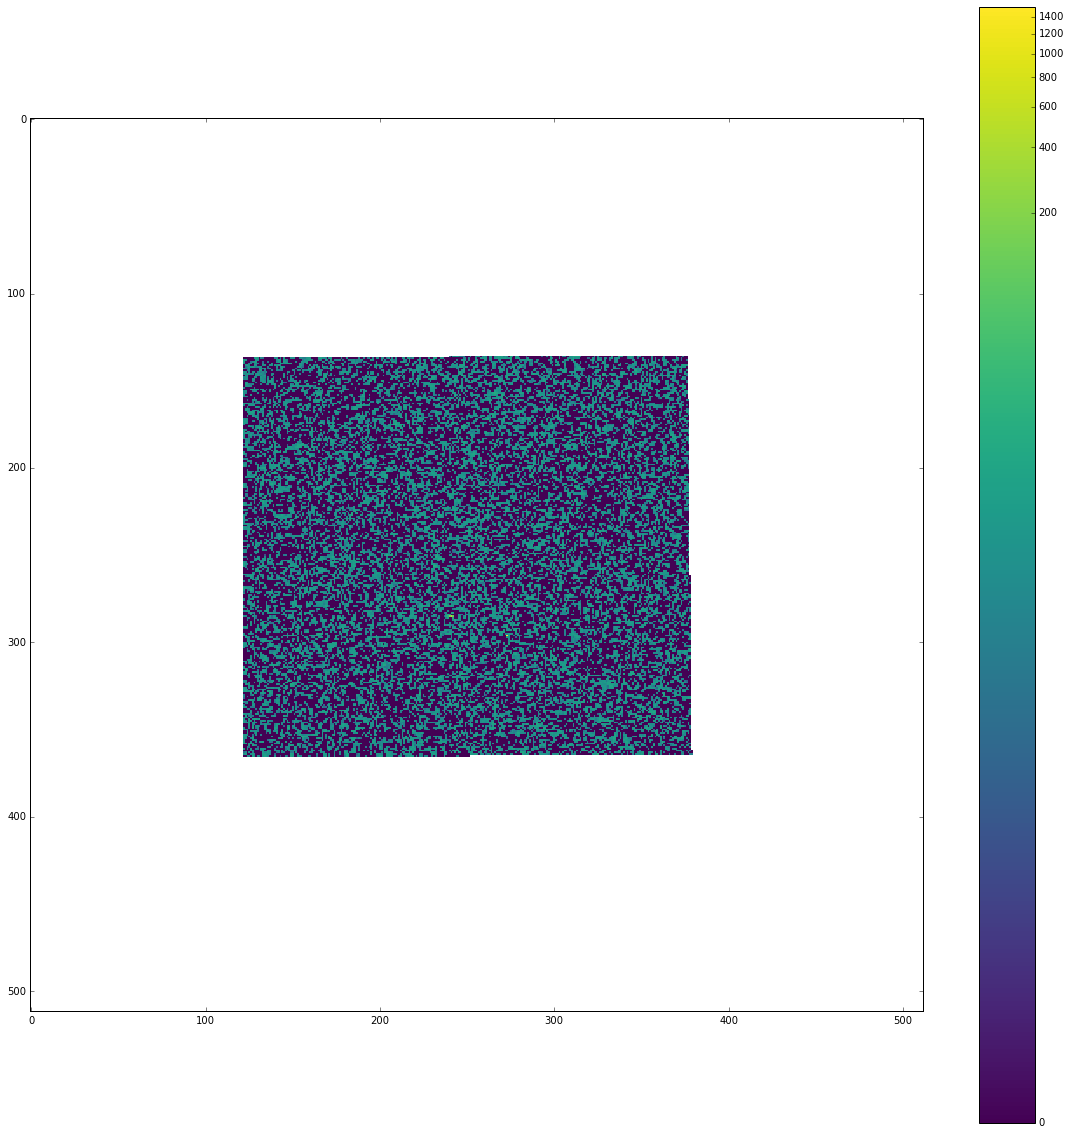

In [18]:
# This subtracts the FIRST single drizzled image from the SECOND

# CONSIDER JUST BLOTTING BACK FIRST IMAGE INTO DISTORTED FRAME OF SECOND
d1 = fits.getdata(flts[0].replace('flt','drz'))
d2 = fits.getdata(flts[1].replace('flt','drz'))
delta = d2-d1
plt.figure(figsize=[20,20])
plt.imshow(delta,cmap='viridis', interpolation='none',norm=PowerNorm(.1))
plt.colorbar()
maxpos, minpos = np.nanargmax(delta), np.nanargmin(delta)
x, y = np.unravel_index([maxpos,minpos], delta.shape)
if os.path.exists('delta_drz.fits'):
    os.remove('delta_drz.fits')
shutil.copy(flts[1].replace('flt','drz'), 'delta_drz.fits')
hdu = fits.open('delta_drz.fits', mode='update')
hdu[1].data=delta
hdu.close()
blot_back('delta_drz.fits',flts[1])
print x, y
print x[0]-x[1], y[0]-y[1]

In [26]:
# This blots back a drizzled image (drz) to some frame (inp) with name (out)

def blot_back(drz, inp, out):
#     teal.teal('ablot')
#     out = inp.replace('flt.fits','delta.fits')
    fits.setval(inp,'MDRIZSKY',value=0.0,ext=1)
    fits.setval(drz,'MDRIZSKY',value=0.0,ext=1)
    print drz, inp, out
    ablot.blot(drz+'[1]',inp+'[1]',out, out_units='cps')
    return out

In [24]:
# This differences some 2 images and saves the difference image, both input images must be the same kind (drz/drz or flt/flt etc)

def diff_ims(im1, im2):
    print os.path.exists(im1)
    d1 = fits.getdata(im1)
    d2 = fits.getdata(im2)
    root1 = im1.split('_')[0]
    root2 = im2.split('_')[0]
    delta = d2-d1
    suffix = im2.split('_')[-1]
    out = '_'.join([root1,root2,'diff',suffix])
    shutil.copy(im2,out)
    hdu = fits.open(out,mode='update')
    hdu[1].data=delta
    hdu.close()
    return out

In [28]:
# Main loop to blot first drz back to all flt frames, and subtract it out

flts = sorted(glob.glob('*flt.fits'))
drzs = sorted(glob.glob('*drz.fits'))
for f in flts:
    out = blot_back(drzs[0],f,f.replace('flt','firstblot'))
    print out
    diff_ims(out, f)

icrr01y7q_drz.fits icrr01y7q_flt.fits icrr01y7q_firstblot.fits
Using coordinate transformation defined by user...
Added 0.0 counts back in to blotted image as sky.
INFO: 
        coefficients from output header, and stripping "-SIP" from output CTYPE
        if it was originally present.

        Therefore astrometry obtained for output image may be different from
        original image because SIP is no longer present.

        Please inspect the headers of input and output images to verify, and
        modify the headers if necessary.
         [astropy.wcs.wcs]
Found RULEFILE for  wfc3  of:  /Users/vbajaj/anaconda2/envs/astroconda/lib/python2.7/site-packages/fitsblender/wfc3_header.rules
Created output image: icrr01y7q_firstblot.fits
icrr01y7q_firstblot.fits
True
icrr01y7q_drz.fits icrr01y8q_flt.fits icrr01y8q_firstblot.fits
Using coordinate transformation defined by user...
Added 0.0 counts back in to blotted image as sky.
INFO: 
        coefficients from output header, and strippin

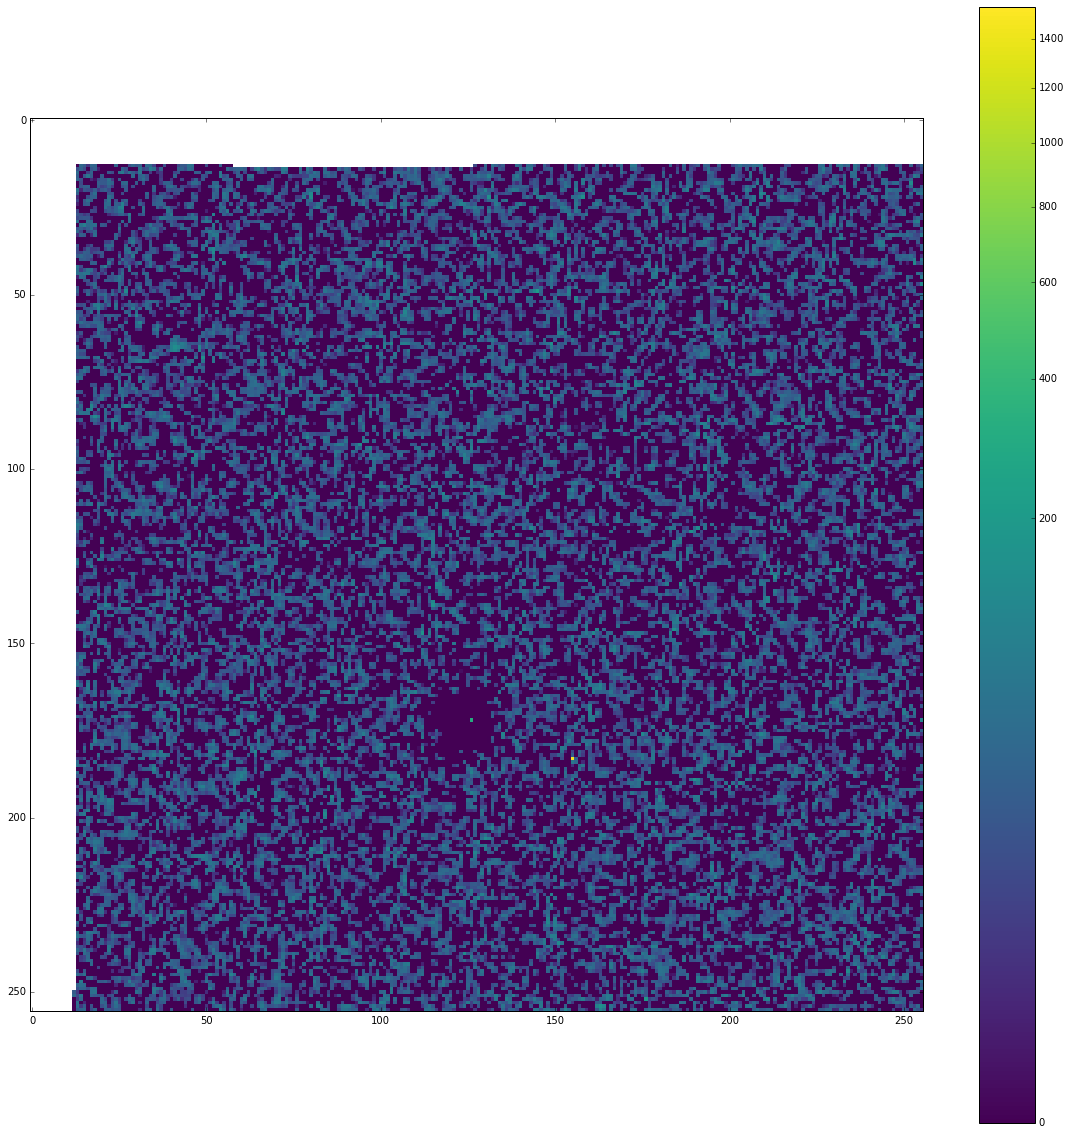

In [8]:
dflt = fits.getdata(flts[1])-fits.getdata(flts[0].replace('flt','next'))
plt.figure(figsize=[20,20])
plt.imshow(dflt,cmap='viridis', interpolation='none',norm=PowerNorm(.3))
plt.colorbar()

In [1]:
pwd

u'/grp/hst/wfc3n/vbajaj/short_term_pers/short_term_persistence/AD_based'